# Bayesian Networks

Consider this document as a "gentle" tutorial form implementing Bayesian networks in Python. We will just review some of the basic lines of code you will need to do some stuff with these networks. In particular, you will see how we can use a simple Bayesian network to solve the Monty Hall problem. 


As usual, we will need to load some libraries first. Notice that we will be using the `pybnn`: type `pip install pybbn` in your terminal to install this library. For more information about this library, please visit https://py-bbn.readthedocs.io/index.html. By the way, this code is based in the code that you can find here: https://towardsdatascience.com/bbn-bayesian-belief-networks-how-to-build-them-effectively-in-python-6b7f93435bba

In [1]:
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs
from pybbn.graph.dag import Bbn # for creating Bayesian Belief Networks (BBN)
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

Now we create the nodes of the Bayesian network and their corresponding conditional probability tables. Notice that these tables are defined exactly in the same way that they were defined in class.

In [2]:
concursante_probabilities = [1/3, 1/3, 1/3]
premio_probabilities = [1/3, 1/3, 1/3]
monty_probabilities = [0, 1/2, 1/2, 
                       0, 0, 1, 
                       0, 1, 0, 
                       0, 0, 1, 
                       1/2, 0, 1/2, 
                       1, 0, 0, 
                       0, 1, 0, 
                       1, 0, 0, 
                       1/2, 1/2, 0]

concursante = BbnNode(Variable(0, 'Concursante', ['1', '2', '3']), concursante_probabilities)
premio = BbnNode(Variable(1, 'Premio', ['1', '2', '3']), premio_probabilities)
monty = BbnNode(Variable(2, 'Monty', ['1', '2', '3']), monty_probabilities)

Now we can create an object for our graph. We need to specify which objects are going to be the nodes and we also need to specify how these are going to be connected. Further, we need to define another object, `join_tree`, which is the one we will use to compute the probabilities of some events given a certain evidence. 

In [3]:
bbn = Bbn() \
    .add_node(concursante) \
    .add_node(premio) \
    .add_node(monty) \
    .add_edge(Edge(concursante, monty, EdgeType.DIRECTED)) \
    .add_edge(Edge(premio, monty, EdgeType.DIRECTED)) \

# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

I find the following lines of code useful because by seeing an image of the graph we just created we can visualize if we defined our Bayesian network correclty. This is particularly useful for more complex networks than the one we just implemented. 

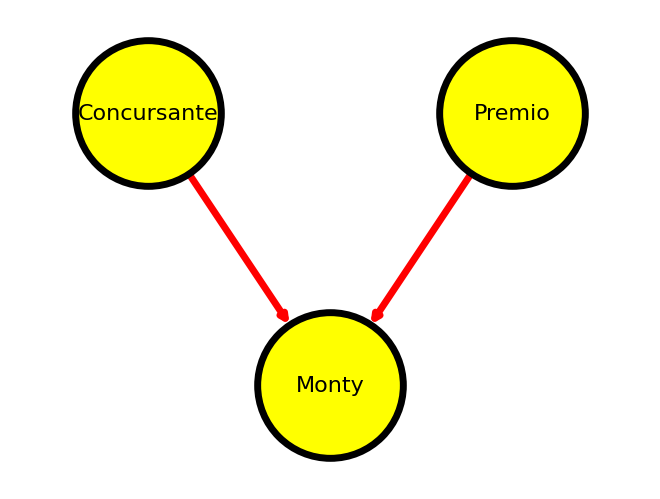

In [4]:
# Set node positions
pos = {0: (-1, 0.5), 1: (1, 0.5), 2: (0, 0)}

# Set options for graph looks
options = {"font_size" : 16, "node_size" : 11000, "node_color" : "yellow", 
           "edgecolors" : "black", "edge_color" : "red", "linewidths" : 5, 
           "width": 5}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.3)
plt.axis("off")
plt.show()

The following function is not completely necessary, but it is useful for printing out the current probabilities of the nodes of our network. You will see that it will be used kind of often.

In [5]:
# Define a function for printing marginal probabilities
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')
    
# Use the above function to print marginal probabilities
print_probs()

Node: 1|Premio|1,2,3
Values:
1=1|0.33333
1=2|0.33333
1=3|0.33333
----------------
Node: 2|Monty|1,2,3
Values:
2=1|0.33333
2=2|0.33333
2=3|0.33333
----------------
Node: 0|Concursante|1,2,3
Values:
0=1|0.33333
0=2|0.33333
0=3|0.33333
----------------


The function `evidence` is not necessary either, however, as you can see, we need to write some lines of code to "add" evidence to our model. This information is used to update the probabilities of the distributions of each node of the Bayesian network. Since this piece of code will be used often it is better to encapsulate these lines within a function.

In [6]:
# To add evidence of events that happened so probability distribution can be recalculated
def evidence(ev, nod, val, like):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(val, like) \
    .build()
    join_tree.set_observation(ev)

Now we can define easily the events we know took place with the function we defined above.

In [7]:
# Use above function to add evidence
evidence('ev1', 'Concursante', '1', 1)
evidence('ev2', 'Monty', '2', 1)

# Print marginal probabilities
print_probs()

Node: 1|Premio|1,2,3
Values:
1=1|0.33333
1=2|0.00000
1=3|0.66667
----------------
Node: 2|Monty|1,2,3
Values:
2=1|0.00000
2=2|1.00000
2=3|0.00000
----------------
Node: 0|Concursante|1,2,3
Values:
0=1|1.00000
0=2|0.00000
0=3|0.00000
----------------


If you need to reset the Bayesian network, rerun this line of code or rerun the above cell twice.

In [ ]:
join_tree = InferenceController.apply(bbn)

## Project of the week

Let us talk now about the project of this week. You collected this data, and by "you collected" I mean you downloaded it from this webpage: https://www.kaggle.com/vikasukani/diabetes-data-set. Let us take a peek into the data.

In [8]:
import pandas as pd

In [9]:
diabetes = pd.read_csv('diabetes-dataset.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


As you can see there are some numbers that tell you something about someone's health, as well as knowing if a given person has diabetes or not. 

Let us assume that this data paints an accurate picture of the diabetes situation around the world. Your mission is to implement a Bayesian network to help doctors to diagnose whether a patient has diabetes or not. But rest assured, you are not alone in this, the doctors will help you with their expertise by giving you the Bayesian network of this problem.

<img src="diabetes.png" alt="Drawing" style="width: 700px;"/>

Keep in mind that the main goal of your network is to compute the probability that a person has diabetes given some evidence: insulin level, age, glucose, etc. Along these lines, as you know, each node has a probability distribution that you will need to determine based on the data that you collected. Also, you can notice that the majority of variables are continuous, except for `Pregnancies` and `Outcome`, however, we are going to discretize these variables using quartiles in the following way: 

In [11]:
diabetes['BMI'][diabetes['BMI'] > 0].describe()

count    1972.000000
mean       32.650101
std         7.241027
min        18.200000
25%        27.500000
50%        32.400000
75%        36.800000
max        80.600000
Name: BMI, dtype: float64

First, you can notice that we are only interested in values that are greater than zero, we do this because we do not want our first quartile to be equal to nothing. Once we do this, then we say that the values that the random variable `BMI` is going to take are `BMI`$<27.5$, $27.5\leq$ `BMI`$<32.4$, $32.4\leq$ `BMI`$<36.8$ and $36.8\leq$`BMI`.

Speaking of `BMI`, you may have noticed that the variable `Overweight` is not part of the data, well, it turns out that we can easily obtain this information by classifying a person whose `BMI` is equal or greater than 25 as someone who is overweight, so tag her/him as a **one**, and if that is not the case, `BMI` below 25, then we assign a **zero** to that person.

At this point you might be wondering, what about probabilities? You will need the data that we already have and a function that you will code that receives the data and a dictionary in which each key is a node and the value of each key is a list with the parents of said node, and returns the tables of each variable, which are also stored in a dictionary; keep in mind that, in this case, the tables are lists. For instance, in the case of the Monty Hall problem, we would have this:

In [ ]:
monty_problem_dictionary = {'Concursante' : [], 'Premio' : [], 
                            'Monty' : ['Concursante', 'Premio']}

So this is what your function receives. What about the output? It should be a dictionary as well:

In [ ]:
monty_problem_tables = {'Concursante' : [1/3, 1/3, 1/3], 'Premio' : [1/3, 1/3, 1/3], 
                            'Monty' : [0, 1/2, 1/2, 
                                       0, 0, 1, 
                                       0, 1, 0, 
                                       0, 0, 1, 
                                       1/2, 0, 1/2, 
                                       1, 0, 0, 
                                       0, 1, 0, 
                                       1, 0, 0, 
                                       1/2, 1/2, 0]}

By the way, the Bayesian network came from this paper: *Mohammadi, Mohtaram, M. Hosseini and H. Tabatabaee. “Using Bayesian Network for the Prediction and Diagnosis of Diabetes.” (2015)*.

So you are all set! Enjoy!